In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [17]:
Amazon_Reviews = pd.read_csv('Reviews.csv')
print(Amazon_Reviews.shape)

(568454, 10)


In [18]:
# trim dataset to get only first 50 lines. For quick test
Amazon_Reviews = Amazon_Reviews.head(50)
print(Amazon_Reviews.shape)

(50, 10)


In [19]:
Amazon_Reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


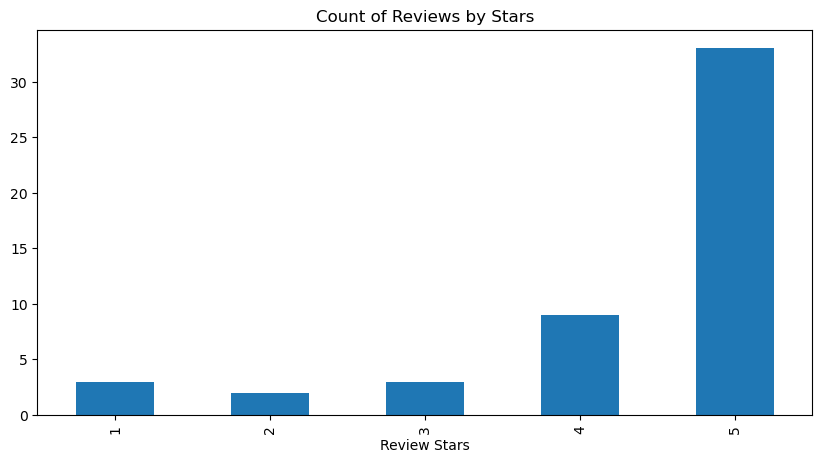

In [20]:
vis = Amazon_Reviews['Score'].value_counts().sort_index().plot(kind = 'bar',
          title = 'Count of Reviews by Stars', figsize = (10, 5))
vis.set_xlabel('Review Stars')
plt.show()

Import pretrained model (Roberta) from hugging face.

Modelhas been trained on twitter comments.

In [9]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [10]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

C:\Users\Samuel-Duke\anaconda3\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Samuel-Duke\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [21]:
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [22]:
res = {}
for i, row in tqdm(Amazon_Reviews.iterrows(), total = len(Amazon_Reviews)):
    try:
        text = row['Text']
        myid = row['Id']
        roberta_result = polarity_scores_roberta(text)
        res[myid] = roberta_result
    except RuntimeError:
        # Roberta model breaks for very long texts
        print(f'Broke for id {myid}, Text too long')

  0%|          | 0/50 [00:00<?, ?it/s]

In [24]:
# create a dataframe using results and merge with original dataset
results = pd.DataFrame(res).T
results = results.reset_index().rename(columns = {'index': 'Id'})
results = results.merge(Amazon_Reviews, how = 'left')
results.head()

,Id,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.003229,0.098068,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [26]:
# rename sentiment columns
results.rename(columns = {"roberta_neg" : "Negative", "roberta_neu" : "Neutral", "roberta_pos" : "Positive"}, inplace = True)
results.head()

,Id,Negative,Neutral,Positive,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.003229,0.098068,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [27]:
# export as csv
results.to_csv("Sentiment on Amazon Reviews.csv")

Type text in directly for sentiment analysis

In [32]:
polarity_scores_roberta("I love AI infrastructure")

{'roberta_neg': 0.004117874,
 'roberta_neu': 0.024753919,
 'roberta_pos': 0.97112817}

In [33]:
polarity_scores_roberta("Programming is an alright experience")

{'roberta_neg': 0.007752515,
 'roberta_neu': 0.08602715,
 'roberta_pos': 0.9062203}

Define a function to return only the highest percentage with the percentage value

In [40]:
def test(text):
    scores = polarity_scores_roberta(text)
    
    max_sentiment = max(scores, key = scores.get)
    max_val = max(scores.values())

    if max_sentiment == 'roberta_neg':
        sentiment = "Negative"
    elif max_sentiment == 'roberta_neu':
        sentiment = "Neutral"
    elif max_sentiment == 'roberta_pos':
        sentiment = "Positive"
    result = f"Text is mostly {sentiment} with a percentage of {round(max_val * 100, 2)}%" 
        
    return result

In [41]:
test("Programming is an alright experience")

'Text is mostly Positive with a percentage of 90.62%'

In [43]:
test("That movie yesterday was boring")

'Text is mostly Negative with a percentage of 97.7%'

In [44]:
test("The food is okay")

'Text is mostly Positive with a percentage of 82.95%'

In [45]:
test("The road trip was basic")

'Text is mostly Negative with a percentage of 57.56%'

In [47]:
test("The arcade is average")

'Text is mostly Negative with a percentage of 80.43%'

In [48]:
test("It wasn't too bad it wasn't great either")

'Text is mostly Negative with a percentage of 44.78%'